In [33]:
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import utils

In [36]:
class QNetwork(nn.Module):
    """
        Feed Forward Neural Net that approximates the policy
    """
    def __init__(self, state_size, action_size, seed, hidden_1_size=200, hidden_2_size=200):
        super(QNetwork, self).__init__()
        """
            ARGS:
            state_size(int):= dimension of each state
            action_size(int):= number of valid actions
            seed(int):= random seed
            hidden_1_size(int):= number of units in the first hidden layer
            hidden_2_size(int):= number of units in the second hidden layer
        """
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, hidden_1_size)
        self.fc2 = nn.Linear(hidden_1_size, hidden_2_size)
        self.fc3 = nn.Linear(hidden_2_size, action_size)
        
    def forward(self, state):
        """
            Builds a network that maps from the state space onto the action space
        """
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        out = self.fc3(x)
        return out

In [59]:
class ReplayBuffer:
    """
        Buffer to store experience tuples
    """
    def __init__(self, action_size, buffer_size, batch_size, seed):
        """
            ARGS:
            action_size(int):= number of valid actions
            buffer_size(int):= max number of experiences the buffer can store
            batch_size(int):= number of experiences to sample from the buffer
            seed(int):= random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple('Experience', field_names=['state',
                                                                'action',
                                                                'reward',
                                                                'next_state',
                                                                'done'])
        self.seed = random.seed(seed)
        
    def add(self, state, action, reward, next_state, done):
        """
            Add an experience to the buffer
            
            Note: No need to remove the oldest experience from the queue as
            the deque class handles this automatically
        """
        exp = self.experience(state, action, reward, next_state, done)
        self.memory.append(exp)
        
    def sample(self):
        """
            Randomly sample a collection of experiences from the buffer
        """
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([exp.state for exp in experiences if exp is not None])).float()
        actions = torch.from_numpy(np.vstack([exp.action for exp in experiences if exp is not None])).long()
        rewards = torch.from_numpy(np.vstack([exp.reward for exp in experiences if exp is not None])).float()
        next_states = torch.from_numpy(np.vstack([exp.next_state for exp in experiences if exp is not None])).float()
        dones = torch.from_numpy(np.vstack([exp.done for exp in experiences if exp is not None]).astype(np.uint8)).float()
        
        return (states, actions, rewards, next_states, dones)
    
    def __len__(self):
        return len(self.memory)

In [171]:
class Agent:
    """
        Agent to interact and learn from the environment
    """
    def __init__(self, state_size, action_size, seed, lr=0.01):
        """
            ARGS:
            state_size(int):= dimension of each state
            action_size(int):= number of valid actions
            seed(int):= random seed
            lr(float):= learning rate
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.lr = lr
        
        #Instantiate the Policy and Target Networks
        self.policy_net = QNetwork(self.state_size, self.action_size, seed=314)
        self.target_net = QNetwork(self.state_size, self.action_size, seed=314)
        self.optimizer = optim.Adam(self.policy_net.parameters(),
                                       lr=self.lr)
        
        #Initialize Replay Memory and time steps
        self.replay_mem = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, self.seed)
        self.t_step = 0
        
    def step(self, state, action, reward, next_state, done):
        #Add to Experience Replay Memory
        self.replay_mem.add(state, action, reward, next_state, done)
        
        self.t_step = (self.t_step+1) % UPDATE_FREQ
        
        #Sample from ERM if enough samples
        if self.t_step == 0:
            if len(self.replay_mem) > BATCH_SIZE:
                experiences = self.replay_mem.sample()
                self.learn(experiences, GAMMA)
                
    def act(self, state, epsilon=0.):
        """
            Chooses an action based on the given state
        """
        state = torch.from_numpy(state).float().unsqueeze(0)
        self.policy_net.eval()
        with torch.no_grad():
            action_values = self.policy_net(state)
        self.policy_net.train()
        
        #Epsilon greedy selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
        
    def learn(self, experiences, gamma):
        """
        
        """
        states, actions, rewards, next_states, dones = experiences
        
        #Get max predicted Q values for subsequent states from the target network
        Q_targets_next = self.target_net(next_states).detach().max(1)[0].unsqueeze(1)
        #Compute Q targets for the current states
        Q_targets = rewards + (gamma * Q_targets_next * (1-dones))
        
        #Get expected Q values from policy network
        Q_expected = self.policy_net(states).gather(1, actions)
        
        #Compute and minimize loss
        loss = F.mse_loss(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        #Update target network using policy network parameters
        self.soft_update(self.policy_net, self.target_net, TAU)
        
    def soft_update(self, policy_network, target_network, tau):
        """
            Soft update the target network params using policy network params according to:
            param_target = tau*param_local + (1 - tau)*param_target
            
            ARGS:
            policy_network(PyTorch Network):= network params will be copied FROM
            target_network(PyTorch Network):= network params will be copied TO
            tau(float):= interpolation factor
        """
        for target_param, policy_param in zip(target_network.parameters(),
                                              policy_network.parameters()):
            target_param.data.copy_(tau*policy_param.data + (1-tau)*target_param.data)

In [172]:
env = gym.make('CartPole-v0')
env.seed(314)

[314]

In [180]:
#Hyperparameters
BUFFER_SIZE = 10000
BATCH_SIZE = 64
GAMMA = 0.99
TAU = 0.001
LR = 0.0005
UPDATE_FREQ = 4
EPSILON = 1.0
EPS_MIN = 0.1

In [181]:
#Instantiate an agent
agent = Agent(state_size=env.observation_space.shape[0],
              action_size = env.action_space.n,
              seed=314,
              lr=LR)

Episode: 100 	Average Reward of Prev 100 Episodes: 19.626 	 Epsilon: 0.645878
Episode: 200 	Average Reward of Prev 100 Episodes: 13.636 	 Epsilon: 0.431091
Episode: 300 	Average Reward of Prev 100 Episodes: 37.091 	 Epsilon: 0.300817
Episode: 400 	Average Reward of Prev 100 Episodes: 128.000 	 Epsilon: 0.221802
Episode: 500 	Average Reward of Prev 100 Episodes: 191.929 	 Epsilon: 0.173876
Episode: 600 	Average Reward of Prev 100 Episodes: 197.949 	 Epsilon: 0.144808
Episode: 700 	Average Reward of Prev 100 Episodes: 194.333 	 Epsilon: 0.127178
Episode: 800 	Average Reward of Prev 100 Episodes: 195.242 	 Epsilon: 0.116484
Episode: 900 	Average Reward of Prev 100 Episodes: 187.515 	 Epsilon: 0.109998
Episode: 1000 	Average Reward of Prev 100 Episodes: 190.091 	 Epsilon: 0.106064
Episode: 1100 	Average Reward of Prev 100 Episodes: 175.000 	 Epsilon: 0.103678
Episode: 1200 	Average Reward of Prev 100 Episodes: 187.343 	 Epsilon: 0.102231
Episode: 1300 	Average Reward of Prev 100 Episodes: 

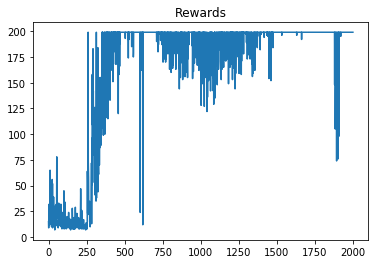

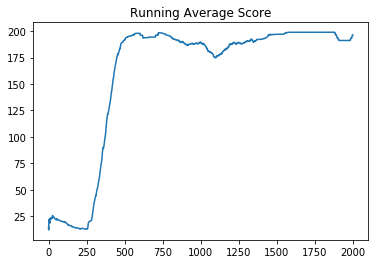

In [182]:
#Training loop
episodes = 2000
total_R = np.empty(episodes)
eps = EPSILON
max_t = 200 #Max number of iterations, gym caps this env at 200
total_iters = 0

for i_ep in range(1, episodes+1):
    state = env.reset()
    done = False
    total_r = 0
    t = 0
    
    while not done and t < max_t:
        action = agent.act(state, eps)
        next_state, reward, done, _ = env.step(action)
        
        if done:
            reward = -200
        
        agent.step(state, action, reward, next_state, done)
        state = next_state

        if reward == 1:
            total_r += reward
        
        t += 1
        
        if done:
            total_iters += t
        
    total_R[i_ep-1] = total_r
    eps = EPS_MIN + (1-EPS_MIN)*np.exp(-0.005*i_ep)
    
    if i_ep % 100 == 0:
        print('Episode: {} \tAverage Reward of Prev 100 Episodes: {:.3f} \t Epsilon: {:.6f}'.format(i_ep,
                                                                                            total_R[i_ep-100:i_ep-1].mean(),
                                                                                            eps))

print('Average reward for last 100 episodes: ', total_R[-100:].mean())
print('Total steps: ', total_iters)

plt.plot(total_R)
plt.title('Rewards')
plt.show()

utils.plot_running_avg(total_R)